# exploring pandemic death data from the US CDC

### not interested in the details?  start [here](#US-deaths-by-natural-causes-since-2014).

- motivation
    - https://www.businessinsider.com/yale-study-excess-deaths-nearly-twice-official-covid-19-count-2020-4?op=1
        - excess deaths exceed deaths officially attributed to covid, in US and elsewhere.
        - reliant on figures from the National Center for Health Statistics (part of the CDC).
        - at a time when traffic fatalities were in steep decline due to stay-at-home orders.
    - here we exclude traffic fatalities, overdoses, suicides, etc by looking only at deaths from natural causes.
    - note that here we ignore specific cause of death, as long as it's a natural cause.
        - these are not just the official covid deaths, but all natural deaths.
- comparisons
    - https://www.cdc.gov/nchs/nvss/vsrr/covid19/excess_deaths.htm
        - 13 "dashboards" but none show the excess deaths directly
        - at best they show excess deaths as part of total deaths, but not as compared with deaths attributed to covid
    - https://coronavirus.jhu.edu/
        - no 'official' vs excess deaths
- data sources
    - mmwr = Morbidity and Mortality Weekly Report
    - baseline 2014-2018
        - https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr
            - json format:  https://data.cdc.gov/resource/3yf8-kanr.json
                - throttled unless you get an app token.
            - pandas format:  https://dev.socrata.com/foundry/data.cdc.gov/3yf8-kanr
                - no app token needed.
    - current 2019-ongoing
        - https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/muzy-jte6
        - updated every Thursday to the week_ending_date (always a Saturday) 12 days earlier.
- background
    - <a id='timeliness'></a>Timeliness of Death Certificate Data  https://www.cdc.gov/nchs/data/vsrr/report001.pdf
        - the most recent data points in the current dataset are undercounts due to delays in reporting.
        - timeliness seems to have improved since this 2015 article, but the delay remains significant.
    - note that 52 weeks X 7 days per week = just 364 days, so each year has an extra day (or two for leap years); thus there is a 53-mmwrweek year every 5-6 years.
    - 2014 is the most recent 53-mmwrweek year.

In [237]:
# to start from zero, run at the commandline: 
# pip install jupyterlab numpy pandas matplotlib sodapy

# external dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sodapy import Socrata

#plt.style.use('dark_background')
#plt.style.use('default')

In [238]:
# data loading details

# here we save the downloaded file for reuse to reduce bandwidth;
# and besides: "Requests made without an app_token will be subject to strict throttling limits."

from os import makedirs
from os.path import join, exists
from pickle import load

data_code_by_dataset = dict(
    current='muzy-jte6',
    baseline='3yf8-kanr',
)


def download_data(data_code, data_path):
    app_token = None  # no token needed for public datasets downloaded via Socrata.
    client = Socrata("data.cdc.gov", app_token)
    data = list(client.get_all(data_code))
    
    # write data to local file
    from pickle import dump
    with open(data_path, 'wb') as f:
        dump(data, f)
        
    return data

def read_local_data(data_path):
    with open(data_path, 'rb') as f:
        data = load(f)
    return data

def read_data(dataset_name):
    data_dir = 'data'
    fname = dataset_name + '.pickl'
    fpath = join(data_dir, fname)
    if not exists(data_dir):
        makedirs(data_dir)
    if exists(fpath):
        return read_local_data(fpath)
    else:
        data_code = data_code_by_dataset[dataset_name]
        return download_data(data_code, fpath)

In [260]:
# load the 2019-2020 "current" dataset (updated weekly)

data = read_data('current')
nlocations = 54
n_extra_rows = len(data) - 2 * 52 * nlocations
print(f'''
    The 2019-2020 dataset is {len(data)} rows, {n_extra_rows} rows (ie {int(n_extra_rows / nlocations)} week) more than 2 years X 52 weeks per year X 54 locations = {2 * 52 * 54} rows
    due to 2020 being a 53-mmwrweek year; 
    the first row is:
    ''')
display(data[0])


    The 2019-2020 dataset is 5670 rows, 54 rows (ie 1 week) more than 2 years X 52 weeks per year X 54 locations = 5616 rows
    due to 2020 being a 53-mmwrweek year; 
    the first row is:
    


{'jurisdiction_of_occurrence': 'Alabama',
 'mmwryear': '2019',
 'mmwrweek': '1',
 'week_ending_date': '2019-01-05',
 'all_cause': '1077',
 'natural_cause': '993',
 'septicemia_a40_a41': '30',
 'malignant_neoplasms_c00_c97': '198',
 'diabetes_mellitus_e10_e14': '22',
 'alzheimer_disease_g30': '60',
 'influenza_and_pneumonia_j09_j18': '21',
 'chronic_lower_respiratory': '63',
 'other_diseases_of_respiratory': '14',
 'nephritis_nephrotic_syndrome': '21',
 'symptoms_signs_and_abnormal': '27',
 'diseases_of_heart_i00_i09': '261',
 'cerebrovascular_diseases': '53',
 'covid_19_u071_multiple_cause_of_death': '0',
 'covid_19_u071_underlying_cause_of_death': '0'}

In [240]:
# create the 2019-2020 dataframe
current_df = pd.DataFrame(data).apply(pd.to_numeric, errors='ignore')

# apparently the flu/pneumonia definition was adjusted between the baseline and current datasets.
# we replace the baseline and current flu/pneumonia columns with a generic name.
flu_col_generic = 'influenza_and_pneumonia_jxx_renamed'
current_df = current_df.rename(columns=dict(
    influenza_and_pneumonia_j09_j18=flu_col_generic,
))

latest_mmwryear = current_df.mmwryear.max()
latest_mmwrweek = current_df.query(f'mmwryear == {latest_mmwryear}').mmwrweek.max()
latest_week_ending_date = current_df.query(f'mmwryear == {latest_mmwryear} and mmwrweek == {latest_mmwrweek}').week_ending_date.unique()[0]
display(f"latest mmwryear is {latest_mmwryear}")
display(f"latest mmwrweek is {latest_mmwrweek}")
display(f"latest week_ending_date is {latest_week_ending_date}")
#display(w.jurisdiction_of_occurrence.unique())
mmwrweek_and_week_ending_date = current_df.query(f"mmwryear == {latest_mmwryear} and jurisdiction_of_occurrence == 'United States'")
mmwrweek_to_week_ending_date = dict(zip(mmwrweek_and_week_ending_date.mmwrweek, mmwrweek_and_week_ending_date.week_ending_date))
display(current_df)

'latest mmwryear is 2020'

'latest mmwrweek is 53'

'latest week_ending_date is 2021-01-02'

,jurisdiction_of_occurrence,mmwryear,mmwrweek,week_ending_date,all_cause,natural_cause,septicemia_a40_a41,malignant_neoplasms_c00_c97,diabetes_mellitus_e10_e14,alzheimer_disease_g30,...,flag_cov19ucod,flag_sept,flag_diab,flag_alz,flag_clrd,flag_stroke,flag_hd,flag_neopl,flag_allcause,flag_natcause
0,Alabama,2019,1,2019-01-05,1077.0,993.0,30.0,198.0,22.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,2019,2,2019-01-12,1090.0,994.0,25.0,187.0,24.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,2019,3,2019-01-19,1114.0,1042.0,22.0,238.0,18.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,2019,4,2019-01-26,1063.0,994.0,21.0,165.0,22.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,2019,5,2019-02-02,1095.0,1026.0,18.0,199.0,19.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5665,United States,2020,49,2020-12-05,69503.0,66434.0,732.0,10429.0,1875.0,2639.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5666,United States,2020,50,2020-12-12,69008.0,66398.0,676.0,10540.0,1846.0,2670.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5667,United States,2020,51,2020-12-19,57654.0,55772.0,589.0,9302.0,1558.0,2506.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5668,United States,2020,52,2020-12-26,41796.0,40643.0,484.0,7240.0,1194.0,1959.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
# combine with baseline death data 2014-2018

data = read_data('baseline')
print(f'\nbaseline has {len(data)} rows')
baseline_df = pd.DataFrame(data).apply(pd.to_numeric, errors='ignore')
yr_min, yr_max = baseline_df.mmwryear.min(), baseline_df.mmwryear.max()
n_yrs = yr_max - yr_min + 1
n_locs = len(baseline_df.jurisdiction_of_occurrence.unique())
print(f'compare with {n_yrs} years X 52 weeks/year * {n_locs} locations =  {n_yrs * 52 * n_locs}')
print(f'thus there is a 53rd mmwr week (in 2014)--this happens every 5 or 6 years\n')

# align column names with latest weekly dataset, for concatenation below
baseline_df = baseline_df.rename(columns=dict(
    weekendingdate="week_ending_date",
    allcause="all_cause",
    naturalcause="natural_cause",
    influenza_and_pneumonia_j10=flu_col_generic,
))

display(baseline_df)


baseline has 14094 rows
compare with 5 years X 52 weeks/year * 54 locations =  14040
thus there is a 53rd mmwr week (in 2014)--this happens every 5 or 6 years



,jurisdiction_of_occurrence,mmwryear,mmwrweek,week_ending_date,all_cause,natural_cause,malignant_neoplasms_c00_c97,alzheimer_disease_g30,chronic_lower_respiratory,symptoms_signs_and_abnormal,...,diabetes_mellitus_e10_e14,influenza_and_pneumonia_jxx_renamed,other_diseases_of_respiratory,nephritis_nephrotic_syndrome,flag_clrd,flag_otherunk,flag_stroke,flag_alz,flag_hd,flag_neopl
0,Alabama,2014,1,2014-01-04T00:00:00.000,355,327,60.0,10.0,20.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,2014,2,2014-01-11T00:00:00.000,872,792,163.0,35.0,61.0,25.0,...,23.0,32.0,14.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,2014,3,2014-01-18T00:00:00.000,1044,971,209.0,31.0,77.0,19.0,...,34.0,33.0,19.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,2014,4,2014-01-25T00:00:00.000,1022,967,205.0,25.0,74.0,35.0,...,23.0,42.0,16.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,2014,5,2014-02-01T00:00:00.000,1040,953,200.0,38.0,68.0,24.0,...,26.0,26.0,15.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14089,United States,2018,48,2018-12-01T00:00:00.000,55210,50797,11405.0,2385.0,3028.0,699.0,...,1725.0,908.0,826.0,1071.0,NaN,NaN,NaN,NaN,NaN,NaN
14090,United States,2018,49,2018-12-08T00:00:00.000,56095,51413,11715.0,2469.0,3017.0,678.0,...,1769.0,962.0,883.0,1053.0,NaN,NaN,NaN,NaN,NaN,NaN
14091,United States,2018,50,2018-12-15T00:00:00.000,56530,52053,11917.0,2508.0,3095.0,665.0,...,1665.0,976.0,862.0,1080.0,NaN,NaN,NaN,NaN,NaN,NaN
14092,United States,2018,51,2018-12-22T00:00:00.000,56689,52035,11753.0,2501.0,3139.0,691.0,...,1754.0,1003.0,913.0,1044.0,NaN,NaN,NaN,NaN,NaN,NaN


In [242]:
all_data = pd.concat([baseline_df, current_df])
loc = 'United States'
loc_data_raw = all_data.query(f"jurisdiction_of_occurrence == '{loc}'")
print(f'\ndata from 2014 thru the present totals {len(loc_data_raw)} rows, whereas 7 years X 52 weeks per year = {7 * 52} weeks (2014 was a 53-mmwrweek year)\n')


data from 2014 thru the present totals 366 rows, whereas 7 years X 52 weeks per year = 364 weeks (2014 was a 53-mmwrweek year)



In [243]:
def select_col(df, col):
    return pd.DataFrame({
        yr: pd.Series(
            df.query(f"mmwryear == {yr}")[col].values,
            index=df.query(f"mmwryear == {yr}").mmwrweek
        )
        for yr in range(2014, 2020+1)
    })
nat_cod_by_yr = select_col(loc_data_raw, 'natural_cause')
print(f'\n{len(nat_cod_by_yr)} rows (because 2014 was a 53-mmwrweek year)\n')
#display('years included: ' + ' '.join(str(yr) for yr in nat_cod_by_yr.columns))
display(nat_cod_by_yr)


53 rows (because 2014 was a 53-mmwrweek year)



,2014,2015,2016,2017,2018,2019,2020
mmwrweek,,,,,,,
1,28636.0,57736.0,51769.0,54964.0,61146.0,53574.0,55015.0
2,51827.0,57143.0,51478.0,56325.0,62704.0,53763.0,55730.0
3,50947.0,54694.0,51263.0,54765.0,60193.0,53807.0,54516.0
4,50503.0,53516.0,51492.0,53451.0,58136.0,53522.0,54393.0
5,50370.0,53279.0,50670.0,53828.0,56384.0,53658.0,54011.0
6,49778.0,52592.0,50907.0,54318.0,56498.0,53737.0,54339.0
7,50175.0,52443.0,51559.0,54045.0,55304.0,53511.0,53971.0
8,48991.0,51862.0,50718.0,53838.0,53353.0,53563.0,53984.0
9,47883.0,51720.0,51580.0,52555.0,52183.0,53281.0,54292.0


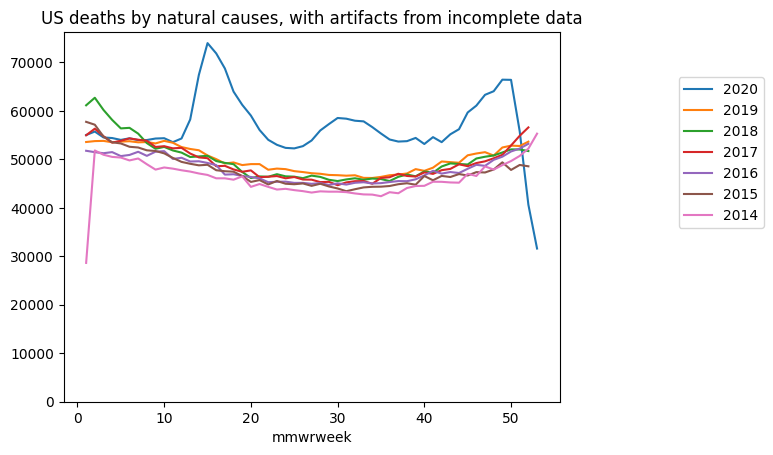

In [244]:
# plot data by year

def plot_df(df, title=None, caption=None, order=None, xylegend=None):
    
    if not xylegend:
        xylegend = (1.15, 0.8)
        
    fig = plt.figure()
    
    if title:
        plt.title(title)
        
    ax = fig.gca()
        # gca stands for 'get current axes'
    if order == 'by_sum':
        columns = [col for summ, col in reversed(sorted((df[col].sum(), col) for col in df.columns))]
    else:
        columns = order(df.columns) if order else df.columns
    # reverse columns so that legend better corresponds to location of data [2020 is uppermost]
    for yr in columns:
        df[yr].plot(kind='line',x='mmwrweek', y='natural_cause', ax=ax)
    
    # set y-axis to start at zero
    ax.set_ylim(bottom=0)
    fig.legend(bbox_to_anchor=xylegend)  #loc='lower right')
    #print(fig.legend.__doc__)
    if caption:
        fig.text(.1, -.15, caption)  #, ha='center')
    
    plt.show()

plot_df(nat_cod_by_yr, 'US deaths by natural causes, with artifacts from incomplete data', order=reversed, xylegend=(1.23,0.8))

In [245]:
# useful code to avoid using the most incomplete recent data points

from itertools import takewhile

# data from a forthcoming notebook, computed from multiple "current" weekly datasets
undercount_from_latest = [1.6488, 0.3082, 0.1064, 0.0564, 0.0365, 0.0248, 0.0163, 0.0136, 0.0131, 0.0136]

def n_weeks_to_ignore_for_max_undercount(max_undercount):
    return len(list(takewhile((lambda x: x > max_undercount), undercount_from_latest)))

def trim_df(df, max_undercount, columns=None):
    if not columns:
        columns = df.columns
    n_most_recent_points_to_remove = n_weeks_to_ignore_for_max_undercount(max_undercount)
    last_mmwrweek_to_keep = latest_mmwrweek - n_most_recent_points_to_remove
    df.loc[df.index > last_mmwrweek_to_keep, columns] = None
    return last_mmwrweek_to_keep, n_most_recent_points_to_remove

# US deaths by natural causes since 2014

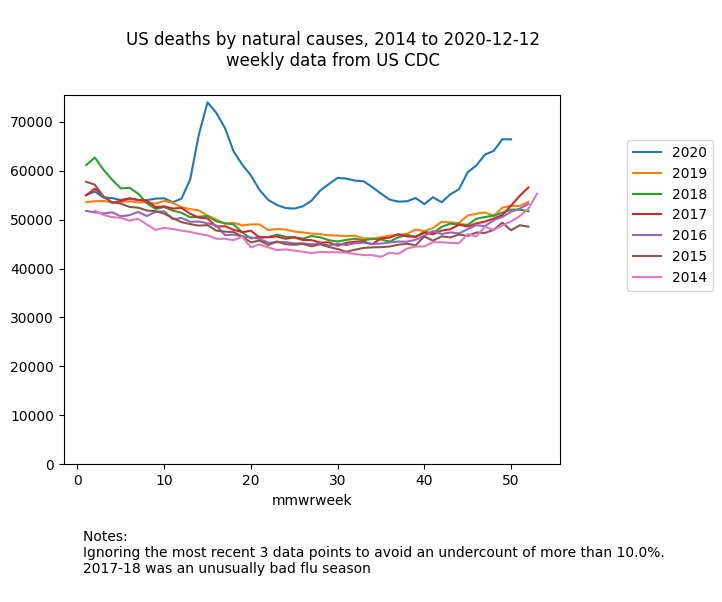

In [246]:
def scrub_df(df):
    # scrub the data in two steps:

    # 1. remove first point in 2014 because it represents only wed-sat of that week [2014 started on a wednesday]
    df[2014][1] = None

    # 2. remove the last few points of the current year because reporting is not yet complete.
    max_undercount = .1   # let's go back far enough to avoid undercounting by more than this much.
    last_mmwrweek_kept, n_most_recent_points_removed = trim_df(df, max_undercount, latest_mmwryear)

    return df

nat_cod_by_yr = scrub_df(nat_cod_by_yr)

# final plot of the scrubbed data

latest_week_ending_date_displayed = mmwrweek_to_week_ending_date[last_mmwrweek_kept]
plot_df(
    nat_cod_by_yr,
    f'''
        US deaths by natural causes, 2014 to {latest_week_ending_date_displayed}
        weekly data from US CDC
    ''',
    caption=f'''
        Notes:
        Ignoring the most recent {n_most_recent_points_removed} data points to avoid an undercount of more than {100 * max_undercount}%.
        2017-18 was an unusually bad flu season
    ''',
    order=reversed
)

So we see much higher weekly deaths from natural causes since week 12.  How many more people are dying than we would expect?
"Excess deaths" may be defined in several ways.
One is to note the generally upward march of the 2014-2019 curves and extrapolate an expected curve for 2020.  This was done in an upcoming notebook, with mixed results.  
But here we simply subtract the deaths in 2019 from those in 2020, which likely gets us close to more sophisticated approaches, with the advantage of simplicity.  Note that 2020 deaths tracked 2019 deaths very closely in the pre-covid period, so this shortcut seems ok.

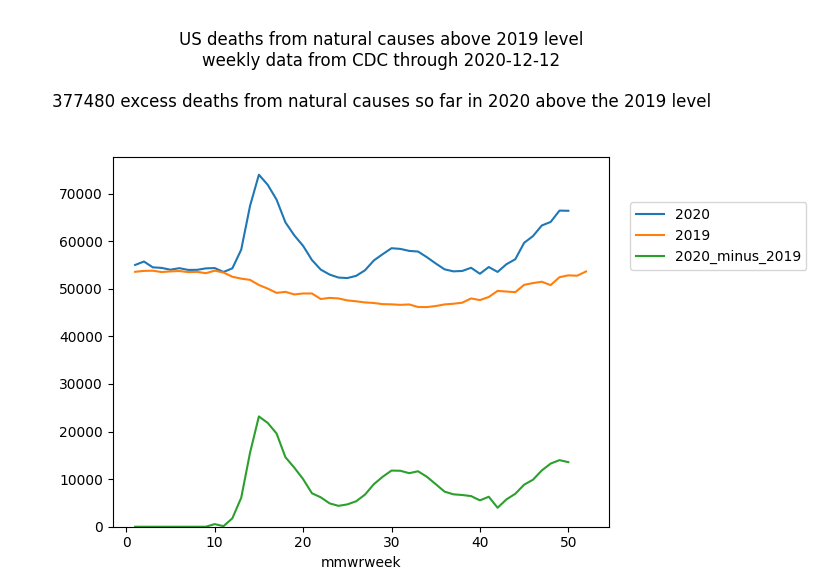

In [247]:
def bracket_pandemic(df, col, final_incomplete_year=None):

    # apply a floor of zero to avoid negative excess deaths
    def floor_zero(x):
        return x if x > 0 else 0
    df[col] = df[col].apply(floor_zero)

    # assume negligible covid deaths in the first weeks of 2020
    last_pre_pandemic_mmwrweek = 9
    nat_cod_by_yr[col].iloc[:last_pre_pandemic_mmwrweek] = 0
    
    # remove future weeks of incomplete year
    if final_incomplete_year:
        nat_cod_by_yr.loc[np.isnan(nat_cod_by_yr[final_incomplete_year]), col] = None
    
    return df

nat_cod_by_yr['2020_minus_2019'] = nat_cod_by_yr[2020] - nat_cod_by_yr[2019]
nat_cod_by_yr = bracket_pandemic(nat_cod_by_yr, '2020_minus_2019', 2020)
plot_df(
    nat_cod_by_yr[[2020, 2019, '2020_minus_2019']],
    title=f'''
        US deaths from natural causes above 2019 level
        weekly data from CDC through {latest_week_ending_date_displayed}
        
        {int(nat_cod_by_yr['2020_minus_2019'].sum())} excess deaths from natural causes so far in 2020 above the 2019 level
        
    ''',
    xylegend=(1.22, 0.8),
)

In [248]:
glance_at_unnatural_causes = 0
if glance_at_unnatural_causes:
    # deaths from all causes are swamped by deaths from natural causes, so let's look at unnatural causes
    # how does that sum compare with the CDC's estimate?
    # the CDC used deaths from all causes, and fancier baseline than simply 2019.  But using all_causes in 2020 minus 2019:
    all_cod_by_yr = scrub_df(select_col(loc_data_raw, 'all_cause'))
    all_cod_by_yr['2020_minus_2019'] = all_cod_by_yr[2020] - all_cod_by_yr[2019]
    plot_df(
        all_cod_by_yr[[2020, 2019, '2020_minus_2019']],
        f'''
            US deaths by all causes, 2019 to 2020
            weekly data from US CDC

            {int(all_cod_by_yr['2020_minus_2019'].sum())} excess deaths from all causes so far in 2020 above the 2019 level
        ''',
        caption=f'''
            Notes:
            Ignoring the most recent {n_most_recent_points_removed} data points to avoid an undercount of more than {int(100 * max_undercount)}%.
        ''',
        xylegend=(1.22, 0.8)
    )

    # deaths from unnatural causes [suicide, overdose, car accidents, etc] are not categorized in this dataset but seem to be reported with yet greater delay.
    unnat_cod_by_yr = all_cod_by_yr - nat_cod_by_yr
    plot_df(unnat_cod_by_yr)

How many of these excess deaths are officially due to covid?

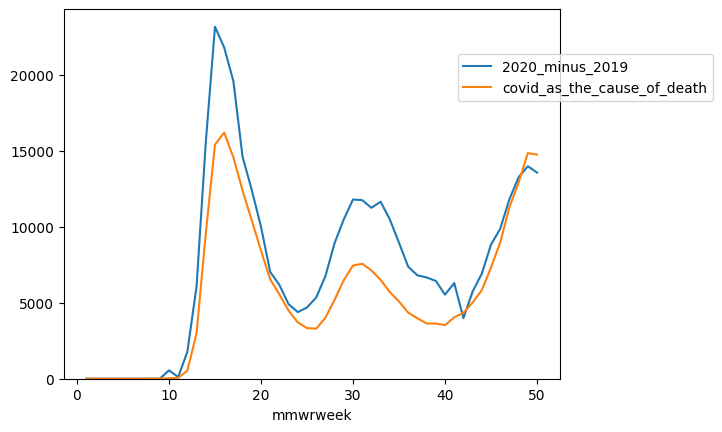

In [249]:
# The CDC MMWR data include deaths of covid as _the_ underlying cause
# and as _one_ contributing cause.

data_us = all_data.query(f"jurisdiction_of_occurrence == '{loc}'")
data_us_2020 = data_us.query(f"mmwryear == 2020")
covid = pd.DataFrame(
    {
        'covid_as_one_cause_of_death': data_us_2020['covid_19_u071_multiple_cause_of_death'].values,
        'covid_as_the_cause_of_death': data_us_2020['covid_19_u071_underlying_cause_of_death'].values,
    },
    index=data_us_2020.mmwrweek
)
trim_df(covid, max_undercount)
x = pd.DataFrame({
    '2020_minus_2019': nat_cod_by_yr['2020_minus_2019'],
    #'covid_as_one_cause_of_death': covid['covid_as_one_cause_of_death'],
        # assuming one_cause includes the_cause since it is always slightly higher.
    'covid_as_the_cause_of_death': covid['covid_as_the_cause_of_death'],
})
plot_df(x)

Covid deaths correlate pretty well with excess deaths, but don't peak as high until the most recent peak-in-the-making, in which covid deaths track total excess deaths very closely.

(Don't put too much stock in that last data point, maybe it should be ignored--see [timeliness](#timeliness) section at the top.)

To check sanity, let's sum all the individual natural causes of death and compare it with the total that we've been using:

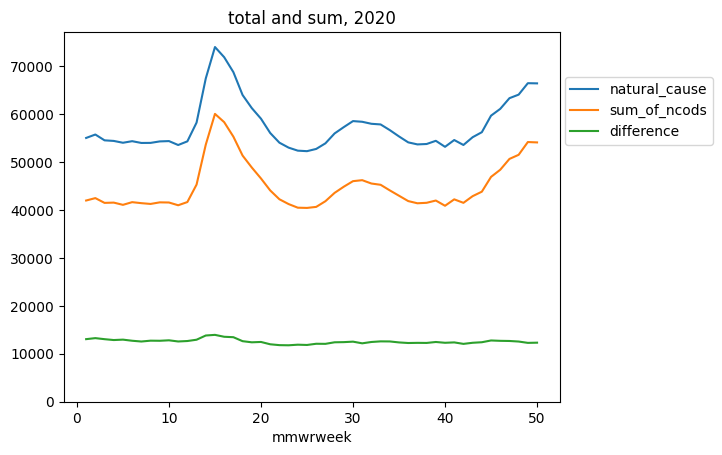

In [250]:
spacetime_columns = ['jurisdiction_of_occurrence', 'mmwryear', 'mmwrweek', 'week_ending_date']
aggregate_columns = ['all_cause', 'natural_cause', 'covid_19_u071_multiple_cause_of_death']
flag_columns = list(col for col in loc_data_raw.columns if col.startswith('flag'))
nondisease_columns = spacetime_columns + aggregate_columns + flag_columns
causes_of_death = list(col for col in loc_data_raw.columns if col not in nondisease_columns)
#print(len(causes_of_death))
#print(causes_of_death)
def sanity(yr):
    df = loc_data_raw.query(f'mmwryear == {yr}')
    #display(df)
    sanity = pd.DataFrame(
        dict(
            natural_cause=df['natural_cause'].values,
            sum_of_ncods=df[causes_of_death].sum(axis=1).values,
            difference=(df['natural_cause'] - df[causes_of_death].sum(axis=1)).values,
            #covid_as_the_cause_of_death=covid['covid_as_the_cause_of_death'],
        ),
        index=df.mmwrweek
    )
    trim_df(sanity, max_undercount)
    plot_df(sanity, title=f'total and sum, {yr}')  #, xylegend=(1.35,.8))
    
sanity(2020)

So the causes of death included in the MMWR are just the major ones--they add up to about 75% of the total deaths from natural causes.  However, the difference is fairly constant, so we can see most of the interesting variation in the individual causes of death in the dataset:

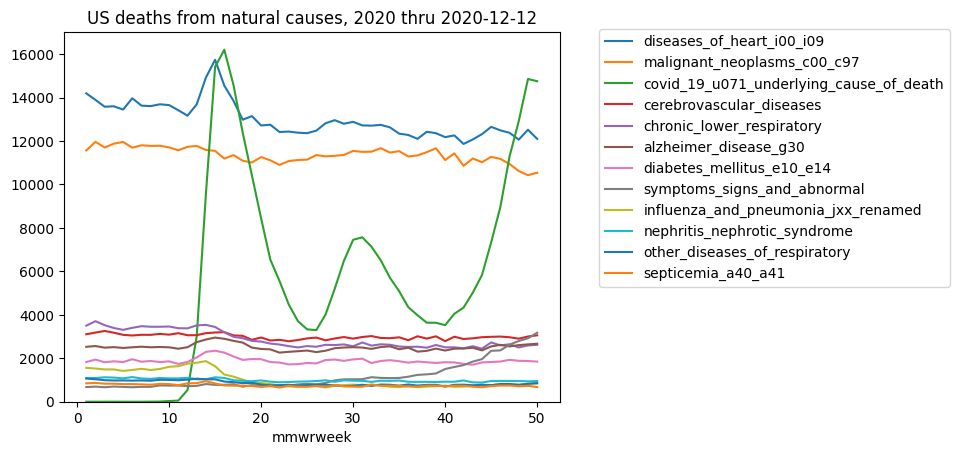

In [251]:
def cods(yr):
    df = loc_data_raw.query(f'mmwryear == {yr}')
    cods = pd.DataFrame(
        {
            key: df[key].values
            for key in causes_of_death
        },
        index=df.mmwrweek
    )
    trim_df(cods, max_undercount)
    plot_df(cods, title=f'US deaths from natural causes, 2020 thru {latest_week_ending_date_displayed}', xylegend=(1.52, 0.9), order='by_sum')
    
cods(2020)

Note:
- the jump in heart disease deaths during the first covid peak (and smaller rises in some other causes of death).
- <a id="abnormal_rise"></a>the gradual rise in "symptoms_signs_and_abnormal" starting at week 30 (adding to [dangling threads](#dangling-threads)).

Presumably there is not usually a springtime peak in heart attacks, but let's check:

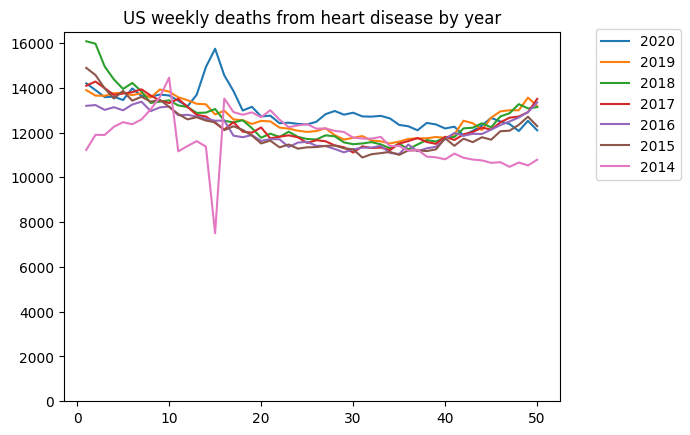

In [252]:
def align53(listt):
    n = len(listt)
    if n < 53:
        listt = np.append(listt, [None] * (53 - n))
    return listt

def plot_cod_thru_yrs(cod, title):
    df = loc_data_raw[['mmwryear', 'mmwrweek', cod]]
    cods = pd.DataFrame(
        {
            yr: align53(df.query(f'mmwryear == {yr}')[cod].values)
            for yr in df.mmwryear.unique()
        },
        index=sorted(df.query(f'mmwryear == 2014').mmwrweek)  # or range(1, 53 + 1)
    )
    trim_df(cods, max_undercount)
    plot_df(cods, title=title, order=reversed, xylegend=(1.1, 0.9))
    
plot_cod_thru_yrs('diseases_of_heart_i00_i09', 'US weekly deaths from heart disease by year')

Indeed, the springtime heart attack peak is unique to 2020.  This peak, and the subsequent excess heart deaths in weeks 25-35, could reflect deaths that should have been attributed to covid, or deaths of people who pre-pandemic would have gone to the hospital and survived but avoided the hospital due to fear of covid.  It will take time for the CDC to tease apart the direct vs indirect deaths due to covid: "it is unclear to what extent these represent misclassified COVID-19 deaths or deaths indirectly related to the pandemic (e.g., because of disruptions in health care access or utilization)" [Excess Deaths Associated with COVID-19, by Age and Race and Ethnicity — United States, January 26–October 3, 2020](https://www.cdc.gov/mmwr/volumes/69/wr/mm6942e2.htm?s_cid=mm6942e2_w)

<a id="heart_disease_2014"></a>2014 stands out as an unusual year for heart disease deaths.  Adding that to [dangling threads](#dangling-threads).

# dangling threads

- 2014 stands out as an unusual year for heart disease deaths (see [here](#heart_disease_2014)).
- the gradual rise in "symptoms_signs_and_abnormal" ([icd10 page](https://icd-codes.com/icd10cm/R00-R99)) starting at week 30 (see [here](#abnormal_rise)).

# next steps

- add dates to mmwr weeks somehow (dates for each mmwr week vary between years)
- explore excess deaths by state/region
- derive undercount_from_latest (a result used above), and correct for it
- compute spatial heat map over time
- want to help?  have a comment?  email me at john@saponara.us or pursue any of the dangling threads and let me know what you find.